In [11]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.56MB/s]


In [3]:
print(len(train_data))
print(len(test_data))

60000
10000


In [4]:
batch = 64
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size=batch, shuffle = False)

In [5]:
class MNISTModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.50),
        nn.Linear(in_features=128*7*7, out_features=10)
    )

  def forward(self, x : torch.Tensor):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)
    return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device

device(type='cuda')

In [7]:
def train_one_epoch(epoch):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += (y_pred.argmax(dim=1) == y).sum().item()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_data)
  print(f"Epoch: {epoch+1} / {epochs} | Train Loss: {train_loss} | Train Acc: {train_acc}")


def evaluate():
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += (test_pred.argmax(dim=1) == y).sum().item()

    test_loss /= len(test_dataloader)
    test_acc /= len(test_data)
  return test_acc

In [10]:
torch.manual_seed(42)
epochs = 10
best_acc = 0
for epoch in tqdm(range(epochs)):
  train_one_epoch(epoch)
  acc = evaluate()
  print(f"Test Acc: {acc}")
  if(acc > best_acc):
    best_acc = acc
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    MODEL_NAME = "digit_recognition_0.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)
print(f"Best Test Accuracy : {best_acc*100}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10 | Train Loss: 0.013866514913927147 | Train Acc: 0.99555
Test Acc: 0.9907
Epoch: 2 / 10 | Train Loss: 0.01877742394778845 | Train Acc: 0.9937666666666667
Test Acc: 0.992
Epoch: 3 / 10 | Train Loss: 0.015406624006536265 | Train Acc: 0.9951333333333333
Test Acc: 0.9914
Epoch: 4 / 10 | Train Loss: 0.01298424055245886 | Train Acc: 0.9957333333333334
Test Acc: 0.9925
Epoch: 5 / 10 | Train Loss: 0.013805537174709372 | Train Acc: 0.9956333333333334
Test Acc: 0.9933
Epoch: 6 / 10 | Train Loss: 0.01661348363462887 | Train Acc: 0.9949166666666667
Test Acc: 0.9908
Epoch: 7 / 10 | Train Loss: 0.01561678565980428 | Train Acc: 0.9948
Test Acc: 0.9944
Epoch: 8 / 10 | Train Loss: 0.012917688957711896 | Train Acc: 0.9954666666666667
Test Acc: 0.994
Epoch: 9 / 10 | Train Loss: 0.011657142362459775 | Train Acc: 0.996
Test Acc: 0.993
Epoch: 10 / 10 | Train Loss: 0.010831631814837867 | Train Acc: 0.9965166666666667
Test Acc: 0.9937
Best Test Accuracy : 99.44%


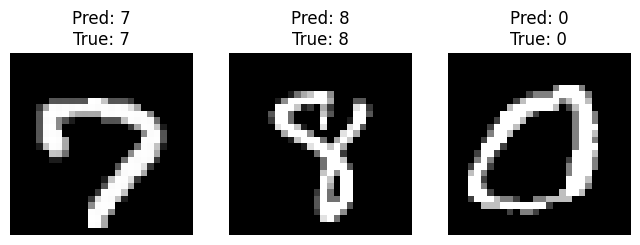

In [17]:
# 1. Load the saved model
loaded_model = MNISTModel().to(device)   # replace MNIST() with your model class
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.eval()

# 2. Get some test samples
import random
rand_indices = random.sample(range(len(test_data)), 3)  # pick 3 random samples

# 3. Visualize predictions
plt.figure(figsize=(8, 3))

for i, idx in enumerate(rand_indices):
    img, label = test_data[idx]
    img = img.to(device)

    with torch.inference_mode():
        pred = loaded_model(img.unsqueeze(0))  # add batch dim
        predicted_label = pred.argmax(dim=1).item()

    # Plot the image
    plt.subplot(1, 3, i+1)
    plt.imshow(img.squeeze().cpu(), cmap="gray")
    plt.title(f"Pred: {predicted_label}\nTrue: {label}")
    plt.axis("off")

plt.show()